use the nolearn environment (source activate nolearn) to run this notebook  
Nolearn documentation: https://github.com/dnouri/nolearn/

## Notes on choosing architechture, hyperparameters, etc.

##### Number of Hidden Layers:
Problems that require two hidden layers are rarely encountered, however, NNs with two hidden layers can represent functions with any kind of shape.  There is currently no theoretical reason to use neural networks with any more than two hidden layers.  (from https://web.archive.org/web/20140721050413/http://www.heatonresearch.com/node/707)

##### Number of neurons in hidden layers:
There are many rule-of-thumb methods for determining the correct number of neurons to use in the hidden layers, such as the following:

-  The number of hidden neurons should be between the size of the input layer and the size of the output layer. 
-  The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer. 
-  The number of hidden neurons should be less than twice the size of the input layer. 
-  Additional rule of thumb for determining an upperbound on the number of hidden neurons that won't result in overfitting is: 

$$ N_h = \frac{N_s}{alpha*(N_i + N_o)} $$

&nbsp;&nbsp;&nbsp;&nbsp; $N_i$ = number of input neurons  
&nbsp;&nbsp;&nbsp;&nbsp; $N_o$ = number of output neurons  
&nbsp;&nbsp;&nbsp;&nbsp; $N_s$ = number of samples in training data set
&nbsp;&nbsp;&nbsp;&nbsp; alpha = arbitrary scaling factor (usually between 2-10)

##### Choosing the Learning Rate
-  First, estimate a threshold value at which the cost on the traning data immediately begins decreasing (do this by changing learning rate by orders of magnitude until you get a value where the cost increases during the first few epochs)
-  This threshold value changes with network architechture and whether the training data is normalized.  Small changes below the threshold value appear to have significant impacts on the results...
-  I need to do more digging into nolearn to determine if I can specify a learning rate schedule, or otherwise adjust the learning rate during training  
--> turns out you can do this fairly easily: see Daniel Nouri's tutorial linked above.

##### Regularization Parameter
Am I able to add regularization with nolearn?  If so, first figure out learning rate without regularization, then add it.  Start with lambda = 1.0, then increase or decrease by factors of 10 to improve performance on the validation data.  After finding best lambda, return and re-optimize the learning rate again.
https://groups.google.com/forum/#!topic/lasagne-users/B3w6_EU9qlI  
https://www.kaggle.com/c/otto-group-product-classification-challenge/forums/t/14139/does-anyone-know-how-to-make-l1-and-l2-regularization-work-for-lasagne  

Should I just add dropout instead?  Both dropout and regularization only make sense if we have a network that is overfitting, so right now it doesn't look like I need it until I can make my network overfit...

To add L1 or L2 regularization, just add objective_l2=0.0001 to the NeuralNet.  
See: https://github.com/dnouri/nolearn/issues/199

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lasagne
from lasagne import layers
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV


%matplotlib inline

# specify the seed for random number generation so we can get consistent 
# shuffling and initialized weights
np.random.seed(6509)

#### Eventually, make this into a function that reads the data, cleans it appropriately, shuffles and normalizes it, and splits it into training/test sets

In [2]:
# Read the training data for the neural network
# Input data is 250000x4 and output data is 250000x32
X = pd.read_csv('../parameters_250000.txt', sep=' ')
Y = pd.read_csv('../results.txt', sep=' ', index_col=False)
# These functional groups do not exist in my model
Y = Y.drop(['light_aromatic_C-C', 'light_aromatic_methoxyl'], axis=1)

X = X.values.astype(np.float32)
Y = Y.values.astype(np.float32)
print X.shape, Y.shape

(250000, 4) (250000, 30)


#### Question:
Is there any reason not to standardize the entire data set at this stage (so scaling parameters will be based on the entire set - training/validation/test sets.  The other option would be to separate the training set out first, then standardize to that set and convert the others later using those parameters.  Any reason to do the latter?

In [3]:
# Standardize the input parameters to have zero mean and unit variance
# x_scaler.transform() can be used later to transform any new data
# x_scaler.inverse_transform() can be used to get the original data back
x_scaler = preprocessing.StandardScaler().fit(X)
x_stand = x_scaler.transform(X)

# Scale the output parameters to lie between 0 and 1
y_scaler = preprocessing.MinMaxScaler().fit(Y)
y_stand = y_scaler.transform(Y)

# Shuffle the dataset (x parameters are varied in a structured way)
combined = np.concatenate((x_stand, y_stand), axis=1)
np.random.shuffle(combined)

In [4]:
# Separate the data into training (with included validation) and test sets.
# (Validation set is separated from the training set by nolearn)
test_fraction = 0.2
training = combined[:-int(test_fraction * combined.shape[0]), :]
test = combined[-int(test_fraction * combined.shape[0]):, :]
print training.shape, test.shape

x_train = training[:, :4]
y_train = training[:, 4:]
x_test = test[:, :4]
y_test = test[:, 4:]

(200000, 34) (50000, 34)


In [10]:
# NeuralNet automatically splits the data provided into a training
# and a validation set, using 20% of the samples for validation. 
# You can adjust this ratio by overriding the eval_size=0.2 parameter.
net = NeuralNet(
            layers=[
                ('input', layers.InputLayer),
                ('hidden1', layers.DenseLayer),
                ('output', layers.DenseLayer)
                ],
            input_shape=(None, x_train.shape[1]),
            hidden1_num_units=18,
            hidden1_nonlinearity=nonlinearities.sigmoid,
            output_num_units=y_train.shape[1],
            output_nonlinearity=nonlinearities.linear,
            regression=True,
            update_learning_rate=0.5,
            verbose=1,
            max_epochs=50,
#             objective_l2=0.0001
#             update_momentum=0.9,
#             update=lasagne.updates.sgd
            # use on_epoch_finished to update the learning rate during training
            # or use early stopping.
            # see https://github.com/dnouri/kfkd-tutorial/blob/master/kfkd.py
            )

# Use this to get all the hyperparameters that make up the estimator.
# Any of these parameters can be optimized with gridsearch
# net.get_params()

In [11]:
# should I use the randomized search instead?
# http://scikit-learn.org/stable/modules/grid_search.html
param_grid = {'hidden1_num_units': [13, 19],
              'update_learning_rate': [0.1, 0.5]
              }

grid_search = GridSearchCV(net, param_grid, verbose=1, n_jobs=4)
grid_search.fit(x_train[:100,:], y_train[:100,:])

Fitting 3 folds for each of 4 candidates, totalling 12 fits
# Neural Network with 485 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input         4
  1  hidden1      13
  2  output       30

# Neural Network with 660 learnable parameters
# Neural Network with 660 learnable parameters
# Neural Network with 660 learnable parameters
# Neural Network with 660 learnable parameters




## Layer information
## Layer information
## Layer information
## Layer information




  #  name       size
---  -------  ------
  0  input         4
  1  hidden1      18
  2  output       30  #  name       size
---  -------  ------
  0  input         4
  1  hidden1      18
  2  output       30  #  name       size
---  -------  ------
  0  input         4
  1  hidden1      18
  2  output       30  #  name       size
---  -------  ------
  0  input         4
  1  hidden1      18
  2  output       30







# Neural Network with 660 learnable parameters
# Neural Netw

[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    5.5s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10e51e650>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10e51e4d0>,
     custom_score=None,
     hidden1_nonlinearity=<function sigmoid at 0x10e03c7d0>,
    ...arning_rate=0.5, use_label_encoder=False, verbose=1,
     y_tensor_type=TensorType(float64, matrix)),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'hidden1_num_units': [13, 19], 'update_learning_rate': [0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [13]:
# grid_search.best_params_
grid_search.grid_scores_

[mean: 0.01288, std: 0.00035, params: {'hidden1_num_units': 13, 'update_learning_rate': 0.1},
 mean: 0.01128, std: 0.00156, params: {'hidden1_num_units': 13, 'update_learning_rate': 0.5},
 mean: 0.01051, std: 0.00143, params: {'hidden1_num_units': 19, 'update_learning_rate': 0.1},
 mean: 0.01089, std: 0.00179, params: {'hidden1_num_units': 19, 'update_learning_rate': 0.5}]

In [71]:
net.fit(x_train[:1000,:], y_train[:1000,:])
print(net.score(x_train, y_train))

# The table that is printed shows the current loss (MSE) on the training and
# validation sets.

# Neural Network with 660 learnable parameters

## Layer information

  #  name       size
---  -------  ------
  0  input         4
  1  hidden1      18
  2  output       30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.04125       0.00709      5.81988  0.02s
      2       0.00649       0.00599      1.08426  0.02s
      3       0.00618       0.00592      1.04479  0.02s
      4       0.00614       0.00589      1.04237  0.02s
      5       0.00611       0.00586      1.04198  0.02s
      6       0.00608       0.00584      1.04186  0.02s
      7       0.00606       0.00582      1.04182  0.02s
      8       0.00603       0.00579      1.04181  0.02s
      9       0.00601       0.00577      1.04184  0.02s
     10       0.00598       0.00574      1.04191  0.02s
     11       0.00596       0.00572      1.04200  0.02s
     12       0.00593       0.00569      1.04213  0.02s
     13       0.00590       0.00566      1

In [72]:
# brute force this process and save all the outputs

# use nolearn.gridsearch to find best hyperparameters

# from sklearn.learning_curve import validation_curve
# train_scores, valid_scores = validation_curve(net, x_train, y_train,
#                                               'update_learning_rate', [0.5, 1],
#                                               verbose=1)

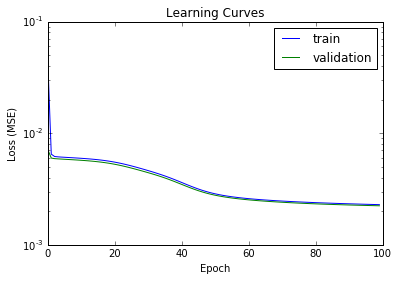

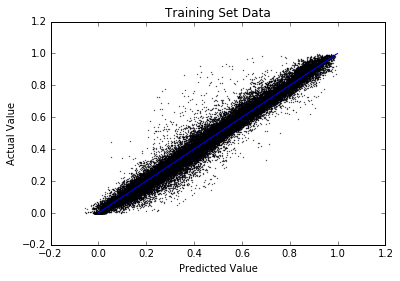

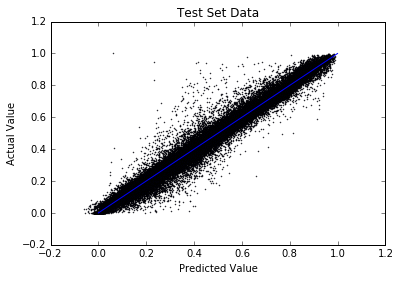

In [73]:
# Plot the learning curves
train_loss = np.array([i["train_loss"] for i in net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net.train_history_])

plt.figure(1)
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')
plt.title('Learning Curves')

# Parity plot of the training data
plt.figure(2)
y_predictions = net.predict(x_train)
plt.scatter(y_predictions[:2000,:].flatten(), y_train[:2000,:].flatten(),
            s=0.1)
plt.plot([np.min(y_train),np.max(y_train)],[np.min(y_train),np.max(y_train)])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Training Set Data')

# Parity plot of the test data
plt.figure(3)
y_predictions_test = net.predict(x_test)
plt.scatter(y_predictions_test[:2000,:].flatten(), y_test[:2000,:].flatten(),
           s=0.2)
plt.plot([np.min(y_test),np.max(y_test)],[np.min(y_test),np.max(y_test)])
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Test Set Data')


In [74]:
# can use net.get_all_params_values() to get all the network params (including 
# weights).

#### Next steps:

- Separate a test set from the training data (x and y above)
- How can I get my network to overfit?
- What objective function is being used by nolearn?  Default is nesterov momentum
- Default loss function for regression is MSE
- What is the exact structure of the network - are bias units added?
- How are weights initialized?
- Why are my training and validation errors so close - validation should start increasing eventually.  Can I make it do this if I train on a smaller dataset?
- Optimize
- pickle the trained model when it is done
- consider scaling the y values so they are all between 0-1
- benchmark the trained model compared with solving the ODEs
- incorporate the ANN into a whole particle model?
- extend the network to predict temporal data by adding time as an input